<a href="https://colab.research.google.com/github/nahumsa/Tensorflow-Quantum/blob/master/Quantum%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Convolutional Neural Networks

This code is based on this [notebook](https://github.com/tensorflow/quantum/blob/master/docs/tutorials/qcnn.ipynb).

## Importing dependencies

In [0]:
!pip install -q tensorflow==2.1.0

In [0]:
!pip install -q tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Quantum CNN

Cirq circuits can be initialized using cirq.GridQubit(N,M), this will generate a grid of qubits (as the name suggests) of size NxM.

To add cirq circuit layers on Tensorflow Quantum that works as a keras.layer using tfq.layers.AddCircuit(), then add the input tensor on the layer as a tensor using the tfq.convert_to_tensor() function.

In [0]:
qubit = cirq.GridQubit(0,0)

# Define Circuits
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert into a tensor
input_circuit_tensor = tfq.convert_to_tensor([circuit1,circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output
output_circuit_tensor = y_appender(input_circuit_tensor,
                                   append=y_circuit)


Checking the output of the tfq.convert_to_tensor() before and after using the tfq.layers.AddCricuit().

As we can see the y_appender only appends the circuit on the previous.

In [8]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(operations=[
        cirq.X.on(cirq.GridQubit(0, 0)),
    ]),
])
 cirq.Circuit([
    cirq.Moment(operations=[
        cirq.H.on(cirq.GridQubit(0, 0)),
    ]),
])]


In [9]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(operations=[
        cirq.X.on(cirq.GridQubit(0, 0)),
    ]),
    cirq.Moment(operations=[
        cirq.Y.on(cirq.GridQubit(0, 0)),
    ]),
])
 cirq.Circuit([
    cirq.Moment(operations=[
        cirq.H.on(cirq.GridQubit(0, 0)),
    ]),
    cirq.Moment(operations=[
        cirq.Y.on(cirq.GridQubit(0, 0)),
    ]),
])]


## Data

The first test data will be excitations to the cluster state. Excitations are represented with cirq.Rx gates. A large enough rotation is labeled an excitation and we label 1 and a rotation that isn't large enough is labeled -1 and called not an excitation.

Considering a rotation $\theta$ :

- if $-\frac{\pi}{2} \leq \theta \leq \frac{\pi}{2}$ then it is considered an excited state.

- Otherwise it is not considered an excited state.

In [0]:
def generate_data(qubits, n_rounds=20, train_split=0.7):
    """Generate training and testing data."""
    
    n_rounds = n_rounds  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * train_split)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [11]:
qbits = cirq.GridQubit.rect(1, 2)
sample_points, sample_labels, _, __ = generate_data(qbits)
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.107π)─── Output: 1
Input: (0, 1): ───Rx(0.943π)─── Output: -1


## Layers of our Quantum Neural network

### Generating a Cluster state

In order to generate a cluster state we apply a controled-Z gate for all qubits using the first qubit as a control.

In [0]:
def cluster_state_circuit(bits):
  """Return a cluster state on the qubits in bits"""
  circuit = cirq.Circuit()
  circuit.append(cirq.H.on_each(bits))
  for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
    circuit.append(cirq.CZ(this_bit, next_bit))
  return circuit

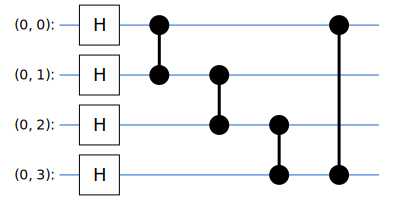

In [15]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

### QCNN

The QCNN layer consists of:
- One and two-qubit paremeterized unitary matrices, that represents the "classical" Convolutional operations.

- A parametrized two-qubit pooling, that represents the "classical" pooling layers.

A one-qubit unitary consists of 3 rotations along X, Y and Z axis.

\begin{equation}
U(\theta,\gamma,\beta) = X^{\theta} Y^{\gamma} Z^{\beta} \left| 0 \right>
\end{equation}

A two-qubit unitary consists of rotations along X, Y and Z axis from both qubits separately and a set of controled rotations XX, YY and ZZ rotations given the same parameters for both qubits.

In a two-qubit pool you want the information of two qubits to be condensed in a single qubit.

In [0]:
def one_qubit_unitary(bit, symbols):
  """ Make a unitary rotation along X, Y and Z
  axis, that depends on the symbols values.
  That means we need 3 'symbols'.
  """  
  assert len(symbols) == 3
  return cirq.Circuit(
                      cirq.X(bit)**symbols[0],
                      cirq.Y(bit)**symbols[1],
                      cirq.Z(bit)**symbols[2]
                      )
  
def two_qubit_unitary(bits, symbols):
  """Arbitrary unitary for 2 qubits.
  We need 15 symbols.
  """
  assert len(symbols) == 15
  circuit = cirq.Circuit()
  
  #Separate unitaries for each qubit
  circuit += one_qubit_unitary(bits[0], symbols[0:3])
  circuit += one_qubit_unitary(bits[1], symbols[3:6])
  
  # ZZ, YY, XX is the tensor product of Z(Y,X) gates
  circuit += [cirq.ZZ(*bits)**symbols[7]]
  circuit += [cirq.YY(*bits)**symbols[8]]
  circuit += [cirq.XX(*bits)**symbols[9]]

  #Separate unitaries for each qubit
  circuit += one_qubit_unitary(bits[0], symbols[9:12])
  circuit += one_qubit_unitary(bits[1], symbols[12:])
  return circuit

def two_qubit_pool(source_qubit, sink_qubit, symbols):
  """Parametrized pooling operation, which attempts to 
  reduce entanglement down from two qubits just to one."""
  
  assert len(symbols) == 6
  pool_circuit = cirq.Circuit()
  
  #Separate unitaries for each qubit
  sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
  source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])  
  pool_circuit.append(sink_basis_selector)
  pool_circuit.append(source_basis_selector)
  
  # Apply CNOT on source_qubit to the sink_qubit
  pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
  
  # Do the inverse sink_basis transformation
  pool_circuit.append(sink_basis_selector**-1)

  return pool_circuit

Visualization of the One Qubit Unitary

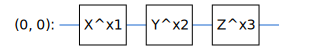

In [17]:
SVGCircuit(
    one_qubit_unitary(
        cirq.GridQubit(0,0), 
        sympy.symbols('x1:4')
                    )
          )

Visualization of the Two Qubit unitary

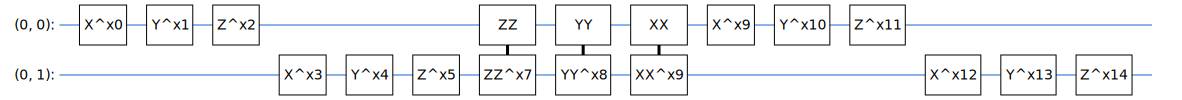

In [0]:
SVGCircuit(
    two_qubit_unitary(
        cirq.GridQubit.rect(1,2),
        sympy.symbols('x0:15')
    )
)

Visualization of the Two Qubit Pooling, the output would be only the (0,1) qubit

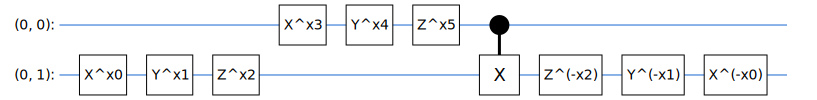

In [0]:
SVGCircuit(
    two_qubit_pool(*cirq.GridQubit.rect(1, 2), 
                   sympy.symbols('x0:6')
                   )
    )

### Quantum Convolutional Layer (QCL)

The QCL consists of two qubit unitaries, parametrized by the same variables, of all qubits in sequence.

In [0]:
def quantum_conv_circuit(bits, symbols):
  """ Quantum Convolution layer.
  Do a two_qubit_unitary for all pairs in bits.
  """
  circuit = cirq.Circuit()
  
  for first, second in zip(bits[0::2], bits[1::2]):
    circuit += two_qubit_unitary([first, second], symbols)
  
  for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
    circuit += two_qubit_unitary([first,second], symbols)

  return circuit

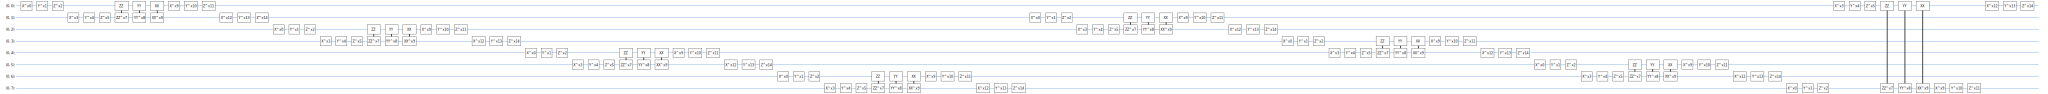

In [19]:
SVGCircuit(
    quantum_conv_circuit(
        cirq.GridQubit.rect(1,8), sympy.symbols('x0:15')
    )
)

### Quantum Pooling Layer (QPL)

The QPL consists of condensing a N qubit circuit into a N/2 qubit circuit.

In [0]:
def quantum_pool_circuit(sources_bits, sink_bits, symbols):
  """Quantum pooling tries to learn relevant information
  from 2 qubits to 1.
  """
  circuit = cirq.Circuit()
  for source, sink in zip(sources_bits, sink_bits):
    circuit += two_qubit_pool(source, sink, symbols)
  
  return circuit

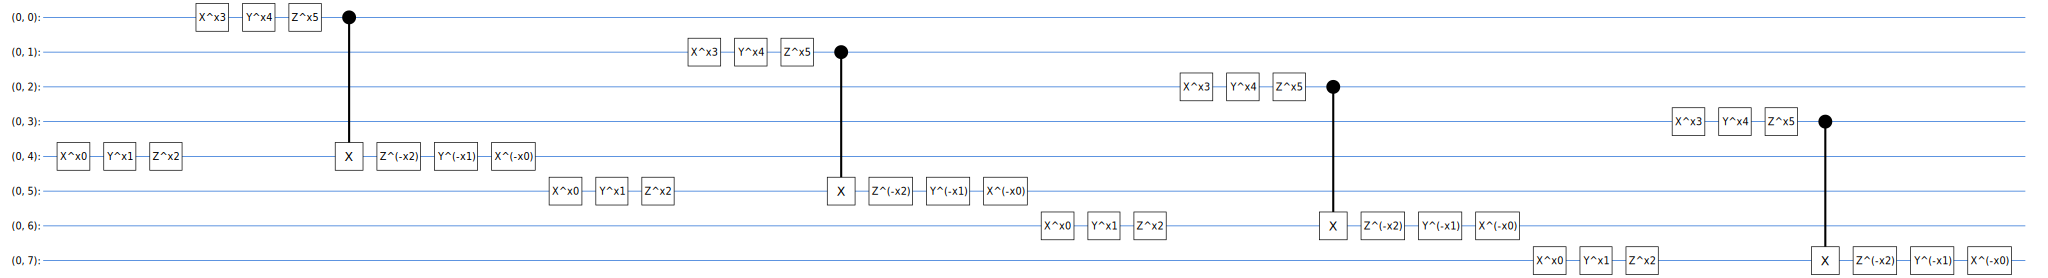

In [21]:
test_bits = cirq.GridQubit.rect(1,8)

SVGCircuit(
    quantum_pool_circuit(
        test_bits[:4], test_bits[4:], sympy.symbols('x0:6')
        )
)

## Model Definition

Construct a QCNN, starting with eight qubits, pooling down to one, then measure $\big< \hat{Z} \big>$.

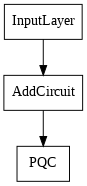

In [25]:
def create_model_circuit(qubits):
  """Create the qCNN that consists of one
  qCNN layer and then a pooling layer for 3
  blocks.
  """
  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:63')

  model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
  model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:], symbols[15:21])
  model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
  model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:], symbols[36:42])
  model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
  model_circuit += quantum_pool_circuit([qubits[6]],[qubits[7]],symbols[57:63])
  
  return model_circuit

#Create qubits and readout_operators
cluster_state_bits = cirq.GridQubit.rect(1,8)
readout_operators = cirq.Z(cluster_state_bits[-1]) #Reading last qubit

#Build a sequential model 
#Input from a cluster state then a QCNN and output measuring <Z>

excitation_input = tf.keras.Input(
                                  shape=(), 
                                  dtype=tf.dtypes.string
                                  )

#Prepend the cluster state generation circuit
cluster_state = tfq.layers.AddCircuit()(
                                        excitation_input, 
                                        prepend=cluster_state_circuit(cluster_state_bits)
                                       )

#Creating a Parametrized Quantum Circuit(PQC)
quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs= [excitation_input],
                            outputs=[quantum_model])

#Show the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=False,
                          show_layer_names=False,
                          dpi=70)

## Training the model

In [0]:
#Generating Data
train_excitations, train_labels, test_excitations, test_labels = generate_data(cluster_state_bits)

#Custom accuracy
@tf.function
def custom_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true)
  y_pred = tf.map_fn(lambda x: 1.0 if x>=0 else -1.0, y_pred)
  return tf.keras.backend.mean(tf.keras.backend.equal(y_true,y_pred))

qcnn_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.05),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy]
                  )

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations,test_labels)
                         )

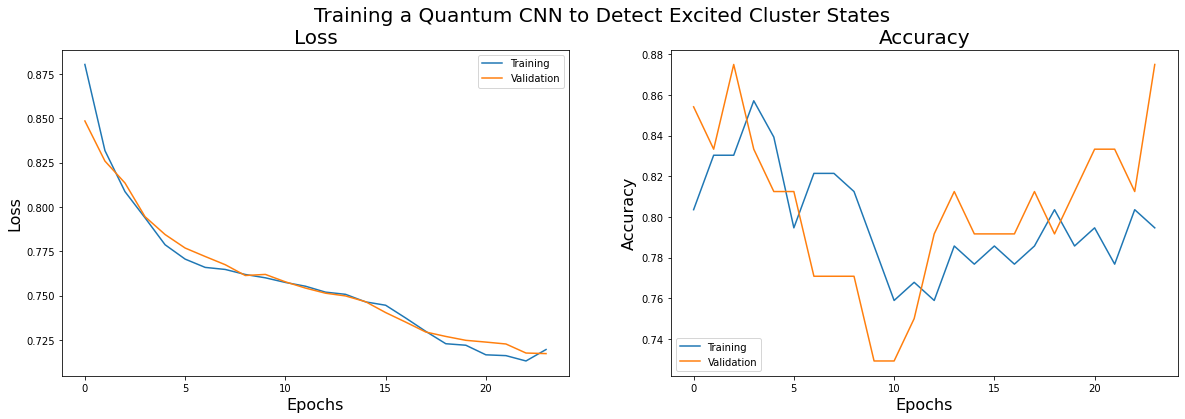

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(history.history['loss'][1:], label='Training')
ax1.plot(history.history['val_loss'][1:], label='Validation')
ax1.set_xlabel('Epochs',size=16)
ax1.set_ylabel('Loss',size=16)
ax1.legend()
ax1.set_title('Loss',size=20)

ax2.plot(history.history['custom_accuracy'][1:], label='Training')
ax2.plot(history.history['val_custom_accuracy'][1:], label='Validation')
ax2.set_xlabel('Epochs',size=16)
ax2.set_ylabel('Accuracy',size=16)
ax2.legend()
ax2.set_title('Accuracy',size=20)

fig.suptitle('Training a Quantum CNN to Detect Excited Cluster States', size=20)
plt.show()

# Hybrid models

## Single Quantum Filter
We can do a partial QCL and then apply a classical dense neural network.

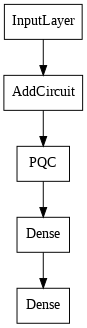

In [28]:
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]

def multi_readout_model_circuit(qubits):
  """Model with only one QCL and onde QPL"""
  model_circuit = cirq.Circuit()
  symbols = sympy.symbols('qconv0:21')
  model_circuit += quantum_conv_circuit(qubits, 
                                        symbols[0:15])
  model_circuit += quantum_pool_circuit(qubits[:4], 
                                        qubits[4:],
                                        symbols[15:21])
  return model_circuit

excitation_input_dual = tf.keras.Input(shape=(),
                                      dtype=tf.dtypes.string)
cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, 
    prepend=cluster_state_circuit(cluster_state_bits)
    )

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts
    )(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)
d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual],
                              outputs=[d2_dual])

# Display model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=False,
                          show_layer_names=False,
                          dpi=70)

In [0]:
hybrid_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy]
                  )
hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels)
                                  )

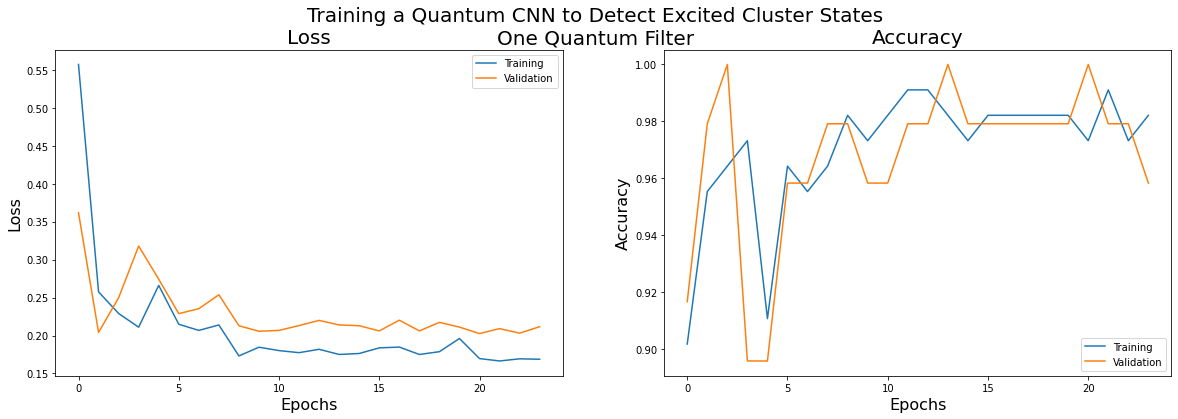

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(hybrid_history.history['loss'][1:], label='Training')
ax1.plot(hybrid_history.history['val_loss'][1:], label='Validation')
ax1.set_xlabel('Epochs',size=16)
ax1.set_ylabel('Loss',size=16)
ax1.legend()
ax1.set_title('Loss',size=20)

ax2.plot(hybrid_history.history['custom_accuracy'][1:], label='Training')
ax2.plot(hybrid_history.history['val_custom_accuracy'][1:], label='Validation')
ax2.set_xlabel('Epochs',size=16)
ax2.set_ylabel('Accuracy',size=16)
ax2.legend()
ax2.set_title('Accuracy',size=20)

fig.suptitle('Training a Quantum CNN to Detect Excited Cluster States\nOne Quantum Filter', size=20)
plt.show()

## Multiple Quantum Filters

For this example it is needed to use the Keras Model API, instead of the Sequential API. Mainly because the Neural Network Graph have more than 1 branch.



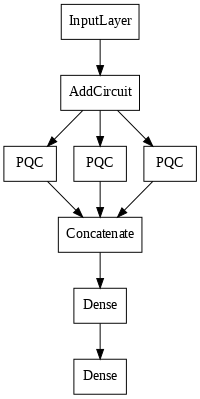

In [31]:
excitation_input_multi = tf.keras.Input(
                                        shape=(),
                                        dtype=tf.dtypes.string
                                       )
cluster_state_multi = tfq.layers.AddCircuit()(
                                              excitation_input_multi,
                                              prepend=cluster_state_circuit(
                                                                            cluster_state_bits)
                                            )

quantum_model_multi1 = tfq.layers.PQC(
                                      multi_readout_model_circuit(cluster_state_bits),
                                      readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
                                      multi_readout_model_circuit(cluster_state_bits),
                                      readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
                                      multi_readout_model_circuit(cluster_state_bits),
                                      readouts)(cluster_state_multi)

#Concatenate layers
concatenate_output = tf.keras.layers.concatenate([quantum_model_multi1,
                                                  quantum_model_multi2,
                                                  quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concatenate_output)
dense_2 = tf.keras.layers.Dense(1)(dense_1)

#Create Model
multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

# Display the model architecture 
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=False,
                          show_layer_names=False,
                          dpi=70)

In [0]:
multi_qconv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                          loss=tf.losses.mse,
                          metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

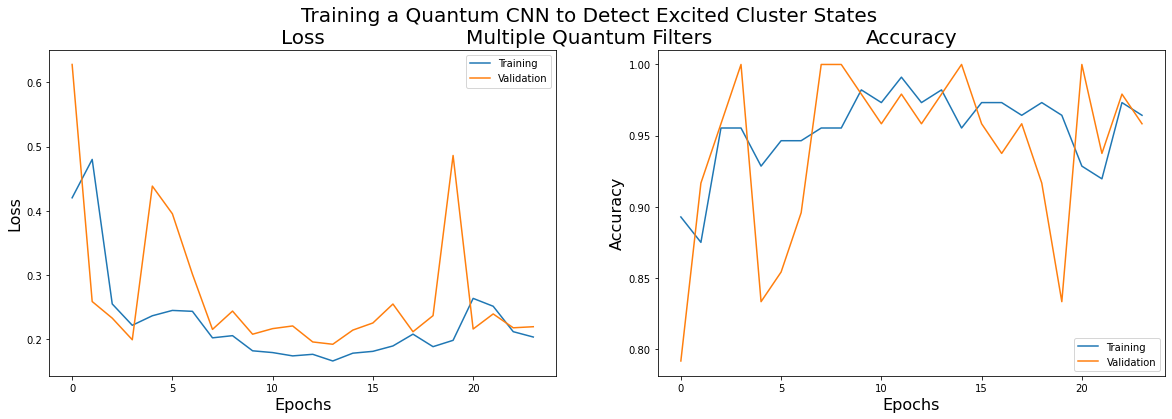

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
ax1.plot(multi_qconv_history.history['loss'][1:], label='Training')
ax1.plot(multi_qconv_history.history['val_loss'][1:], label='Validation')
ax1.set_xlabel('Epochs',size=16)
ax1.set_ylabel('Loss',size=16)
ax1.legend()
ax1.set_title('Loss',size=20)

ax2.plot(multi_qconv_history.history['custom_accuracy'][1:], label='Training')
ax2.plot(multi_qconv_history.history['val_custom_accuracy'][1:], label='Validation')
ax2.set_xlabel('Epochs',size=16)
ax2.set_ylabel('Accuracy',size=16)
ax2.legend()
ax2.set_title('Accuracy',size=20)

fig.suptitle('Training a Quantum CNN to Detect Excited Cluster States\nMultiple Quantum Filters', size=20)
plt.show()

# Comparing Models

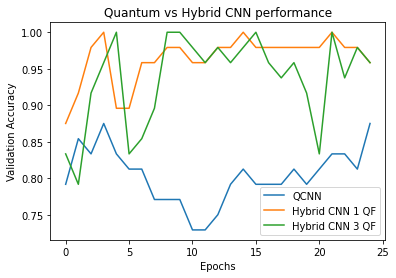

In [35]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN 1 QF')
plt.plot(multi_qconv_history.history['val_custom_accuracy'], label='Hybrid CNN 3 QF')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()